Este cuaderno de Jupyter se basa en el análisis de datos disponibles en la carpeta de Datasets y se utiliza para entrenar diversos algoritmos con el fin de comparar sus métricas en conjuntos de datos de prueba.

**Resultados**  
En el contexto de la problemática abordada en este trabajo de grado, nuestra atención se centra en la métrica de Recall. El algoritmo que mejor se desempeña según esta métrica es Random Forest, con un recall del 76%, además de ofrecer tiempos de respuesta más eficientes en comparación con los otros. Es importante señalar que, dado que este algoritmo se empleará en una aplicación web, la velocidad de respuesta se convierte en un factor crítico. Además, Random Forest demuestra ser el más efectivo en la clasificación de la clase 1.

**Conclusiones**  
Nuestro análisis revela que, en el caso de una base de datos con un número limitado de observaciones y una ligera desigualdad en la distribución de clases, todos los algoritmos presentan un mejor rendimiento en la clasificación de la clase 0.

In [50]:
#importamos librerías
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
import plotly.graph_objects as go
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier 
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier

In [34]:
def loadDbtoFit():
        #leo las bases de datos 
        usuario = pd.read_csv('../Datasets/usuario.csv', delimiter=",", encoding="utf-8")
        megusta = pd.read_csv('../Datasets/megusta.csv', delimiter=",", encoding="utf-8")
        ustage = pd.read_csv('../Datasets/user_stage.csv', delimiter=",", encoding="utf-8")
        perros = pd.read_csv('../Datasets/RDB.csv', delimiter=",", encoding="utf-8")
        app_user = pd.read_csv('../Datasets/app_user.csv', delimiter=",", encoding="utf-8")
        usuario = usuario.drop(['cluster', 'ciclovia', 'locha', 'disciplina', 'silencio', 'amigos', 'pyState', 'fpy'], axis=1)
        #usuario, megusta, ustage, app_user = self.loadDataframeFromDB()
        result = pd.merge(usuario, ustage, on='userid')
        result = pd.merge(result, app_user, on='userid')
        mean_rate=[]
        for index, row in result.iterrows():
            m = megusta[megusta['userid']==row['userid']]['megusta'].mean()
            mean_rate.append(m)
        result['mean_rate']=mean_rate
        result2 = pd.merge(result, megusta, on='userid')
        indexUserid = result2[ (result2['userid'] <16)].index
        result2.drop(indexUserid , inplace=True)
        indexUserid = result2[ (result2['mean_rate'] == 5.000000) | (result2['mean_rate'] == 1.000000) ].index
        result2.drop(indexUserid , inplace=True)
        result3 = pd.merge(result2,  perros, on='perroid')
        result3 = result3.drop([ 'Nombre', 'Raza', 'Fundacion', 'Necesidades', 'cluster' ], axis=1)
        result3['viajes'] = result3['viajes'].apply(lambda x: "y" if x == 1 else "n")
        result3['megusta'] = result3['megusta'].apply(lambda x: "y" if x == 5 else "n")
        result3['atencionesespeciales'] = result3['atencionesespeciales'].apply(lambda x: "y" if x == 1 else "n")
        result3['ninos'] = result3['ninos'].apply(lambda x: "y" if x == 1 else "n")
        result3['entrenado'] = result3['entrenado'].apply(lambda x: "y" if x == 1 else "n")
        result3['esterilizado'] = result3['esterilizado'].apply(lambda x: "y" if x == 1 else "n")
        result3['perros'] = result3['perros'].apply(lambda x: "y" if x == 1 else "n")
        result3['actividad_y'] = result3['actividad_y'].apply(lambda x: "y" if x == 1 else "n")
        result3['rangoEdadPerro']=result3['Edad'].apply(lambda x: "a" if x<5 else ( "b" if (x>=5 and x<10) else "c"))
        result3['rangoEdadH']=result3['edad'].apply(lambda x: "a" if x<20 else ( "b" if (x>=20 and x<30) else ( "c" if (x>=30 and x<40) else "d")))
        result3 = result3.drop(['stage', 'mean_rate', 'provider', 'edad', 'Edad', 'rated_date'], axis=1)
        encoder = ce.OneHotEncoder(cols=['rangoEdadPerro', 'rangoEdadH', 'viajes', 'tipofamilia', 'actividad_x', 'salir', 'estilo', 'vivienda', 'estrato', 'sueldo', 'trabajo', 'tamano', 'sexo', 'color', 'pelaje', 'agresividad', 'atencionesespeciales', 'ninos', 'entrenado', 'esterilizado', 'perros', 'actividad_y'])
        X = encoder.fit_transform(result3.drop(['megusta'], axis=1))
        return X, result3

In [20]:
# creamos funcion para separar la base de datos 70% entrenamiento 30% prueba en donde ambas bases de datos tengan los mismo usuario
import random


def split_train_test(x):
    test_size=0.3
    uids = x['userid'].unique()
    updict = dict()
    xtest = dict()
    xtrain = dict()
    for u in uids:
        updict[u]=[]
        xtest[u]=[]
        xtrain[u]=[]
    for idx, row in x.iterrows():
        updict[row['userid']].append(row['perroid'])
    for u in uids:
        plist = updict[u]
        count = round(len(plist)*test_size)
        testchoices = random.sample(plist, k=count)
        trainchoices = list(set(plist).difference(testchoices))
        xtest[u].append(testchoices)
        xtrain[u].append(trainchoices)
    xtestdf = pd.DataFrame(columns=x.columns)
    xtraindf = pd.DataFrame(columns=x.columns)
    for u in uids:
        for p in xtest[u]:
            xtestdf = pd.concat([xtestdf, x.loc[(x.userid == u) & (x.perroid.isin(p))]])
    for u in uids:
        for p in xtrain[u]:
            xtraindf = pd.concat([xtraindf, x.loc[(x.userid == u) & (x.perroid.isin(p))]])
    xtraindf[x.columns] = xtraindf[x.columns].astype(str).astype("uint8")
    xtestdf[x.columns] = xtestdf[x.columns].astype(str).astype("uint8")
    return xtest, xtrain, xtestdf, xtraindf

In [38]:
X, result = loadDbtoFit()
y_encoder = ce.OneHotEncoder(cols=['megusta'])
resp = y_encoder.fit_transform(result['megusta'])
X['megusta_1'] = resp['megusta_1']
X['megusta_2'] = resp['megusta_2']
dictest, dictrain, dftest, dftrain = split_train_test(X)
X_train=dftrain.drop(['megusta_1', 'megusta_2', 'userid', 'perroid'], axis=1)
X_test=dftest.drop(['megusta_1', 'megusta_2', 'userid', 'perroid'], axis=1)
y_train=dftrain['megusta_1'] #megusta = 1, no me gusta = 0
y_test=dftest['megusta_1']

# **XGBoost**
 

In [39]:
xgmodel = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

cv    = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,test) for train, test in cv.split(X_train, y_train)]
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss'
}


dtest = xgb.DMatrix(X_test, label=y_test)
for train, test in folds:
    dtrain = xgb.DMatrix(X_train.iloc[train,:], label=y_train.iloc[train])
    dval   = xgb.DMatrix(X_train.iloc[test,:], label=y_train.iloc[test])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))

c:\Users\maris\VS Workspace\doggynator\models\doggynatorEnv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [40]:
kind = 'val'
c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(100):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')

In [42]:
xgmodel.fit(X_train, y_train)
y_train_pred = xgmodel.predict(X_train)
y_test_pred = xgmodel.predict(X_test)
train_fpr_xgb, train_tpr_xgb, tr_thresholds_xgb = roc_curve(y_train, y_train_pred)
test_fpr_xgb, test_tpr_xgb, te_thresholds_xgb = roc_curve(y_test, y_test_pred)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       670
           1       0.71      0.58      0.64       391

    accuracy                           0.76      1061
   macro avg       0.74      0.72      0.73      1061
weighted avg       0.75      0.76      0.75      1061



# **LightGBM**

[20]	training's binary_logloss: 0.473061	valid_0's binary_logloss: 0.499924
[40]	training's binary_logloss: 0.441244	valid_0's binary_logloss: 0.487637
[60]	training's binary_logloss: 0.420906	valid_0's binary_logloss: 0.484015
[80]	training's binary_logloss: 0.403277	valid_0's binary_logloss: 0.485329
[100]	training's binary_logloss: 0.388142	valid_0's binary_logloss: 0.48737


c:\Users\maris\VS Workspace\doggynator\models\doggynatorEnv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

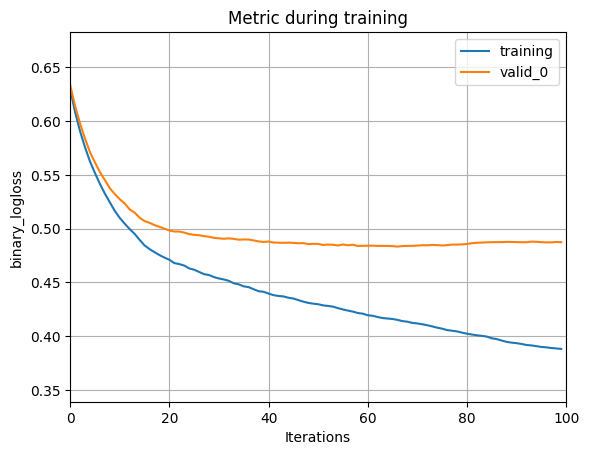

In [62]:
model = lgb.LGBMClassifier(learning_rate=0.1,max_depth=5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')
lgb.plot_metric(model)

In [63]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       670
           1       0.75      0.57      0.65       391

    accuracy                           0.77      1061
   macro avg       0.77      0.73      0.74      1061
weighted avg       0.77      0.77      0.76      1061



# **Random Forest**

In [51]:
clf = RandomForestClassifier(max_depth= 17, min_samples_leaf= 3, min_samples_split= 5, n_estimators= 50)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       670
           1       0.72      0.59      0.65       391

    accuracy                           0.76      1061
   macro avg       0.75      0.73      0.73      1061
weighted avg       0.76      0.76      0.76      1061



# **SGDClassifier**

In [45]:
model = SGDClassifier(loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class, not the predicted outputs.
y_train_pred = model.predict(X_train)    
y_test_pred = model.predict(X_test) 
train_fpr_sgd, train_tpr_sgd, tr_thresholds_sgd = roc_curve(y_train, y_train_pred)
test_fpr_sgd, test_tpr_sgd, te_thresholds_sgd = roc_curve(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       670
           1       0.54      0.64      0.59       391

    accuracy                           0.67      1061
   macro avg       0.65      0.66      0.66      1061
weighted avg       0.68      0.67      0.67      1061



# **GNB**

## Gaussian Naive Bayes

In [46]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB
# instantiate the model
gnb = GaussianNB()
# fit the model
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       670
           1       0.51      0.32      0.39       391

    accuracy                           0.64      1061
   macro avg       0.59      0.57      0.57      1061
weighted avg       0.61      0.64      0.61      1061



## Categorical Naive Bayes classifier

In [47]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import CategoricalNB
# instantiate the model
gnbcat = CategoricalNB()
# fit the model
gnbcat.fit(X_train, y_train)
y_pred = gnbcat.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       670
           1       0.55      0.52      0.54       391

    accuracy                           0.67      1061
   macro avg       0.64      0.64      0.64      1061
weighted avg       0.67      0.67      0.67      1061



## BernoulliNB

In [48]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import BernoulliNB
# instantiate the model
gnbBer = BernoulliNB()
# fit the model
gnbBer.fit(X_train, y_train)
y_pred = gnbBer.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       670
           1       0.55      0.52      0.54       391

    accuracy                           0.67      1061
   macro avg       0.64      0.64      0.64      1061
weighted avg       0.67      0.67      0.67      1061



## Multinomial NB

In [49]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import MultinomialNB
# instantiate the model
gnbM = MultinomialNB()
# fit the model
gnbM.fit(X_train, y_train)
y_pred = gnbM.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       670
           1       0.56      0.42      0.48       391

    accuracy                           0.66      1061
   macro avg       0.63      0.61      0.62      1061
weighted avg       0.65      0.66      0.65      1061

